# 02 - Data from the Web

In [2]:
# Needed imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import difflib
import seaborn as sns
%matplotlib inline

## Some helper functions we need

In [18]:
def parseInt(numStr):
    cleaned = [x for x in numStr if x.isdigit()]
    return int("".join(cleaned))

def parseDecimal(numStr):
    cleaned = [x for x in numStr if x.isdigit() or x == '.']
    return float("".join(cleaned))

## Task 1
- Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)) 

In [3]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt')
qs_dataset = r.json()['data']

In [4]:
qs_dataset[0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

- For each university, we extract: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). The detailed information (faculty and students) is gathered from the respective page of each university. 

In [ ]:
results = []
for university in qs_dataset[:200]:
    url = 'https://www.topuniversities.com' + university['url']
    details_html = requests.get(url)
    soup = BeautifulSoup(details_html.text, 'html.parser')

    def parseAttribute(className):
        attr = soup.find('div', class_=className)
        if attr is not None:
            return parseInt(attr.find('div', class_='number').text)
        else:
            return 0 # Missing value
        
    results.append({
            'name': university['title'],
            'rank': parseInt(university['rank_display']),
            'country': university['country'],
            'region': university['region'],
            'faculty_international': parseAttribute('inter faculty'),
            'faculty_total': parseAttribute('total faculty'),
            'students_international': parseAttribute('total inter'),
            'students_total': parseAttribute('total student')
        })

- Convert the resulting dataset into a DataFrame and store it as a file (for reusing it later without parsing the content again).

In [5]:
qs_df = pd.DataFrame.from_dict(results).set_index('name')
qs_df.to_pickle('qs_dataset')

NameError: name 'results' is not defined

In [6]:
qs_df = pd.read_pickle('qs_dataset')
qs_df.head()

,country,faculty_international,faculty_total,rank,region,students_international,students_total
name,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679,2982,1,North America,3717,11067
Stanford University,United States,2042,4285,2,North America,3611,15878
Harvard University,United States,1311,4350,3,North America,5266,22429
California Institute of Technology (Caltech),United States,350,953,4,North America,647,2255
University of Cambridge,United Kingdom,2278,5490,5,Europe,6699,18770


- We now add two new columns 'faculty_students_ratio' (which represenst the faculty-to-students ratio) and 'international_ratio' (which represents the fraction of international students) so that, by sorting along these columns we can find the best universities in terms of (a) ratio between faculty members and students and (b) ratio of international students.

In [7]:
qs_df['faculty_students_ratio'] = qs_df['faculty_total']/qs_df['students_total']
qs_df['international_ratio'] = qs_df['students_international']/qs_df['students_total']
qs_df.head()

,country,faculty_international,faculty_total,rank,region,students_international,students_total,faculty_students_ratio,international_ratio
name,,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679,2982,1,North America,3717,11067,0.269450,0.335863
Stanford University,United States,2042,4285,2,North America,3611,15878,0.269870,0.227422
Harvard University,United States,1311,4350,3,North America,5266,22429,0.193945,0.234785
California Institute of Technology (Caltech),United States,350,953,4,North America,647,2255,0.422616,0.286918
University of Cambridge,United Kingdom,2278,5490,5,Europe,6699,18770,0.292488,0.356899


In [8]:
qs_df.sort_values('faculty_students_ratio', ascending=False).head()

,country,faculty_international,faculty_total,rank,region,students_international,students_total,faculty_students_ratio,international_ratio
name,,,,,,,,,
California Institute of Technology (Caltech),United States,350,953,4,North America,647,2255,0.422616,0.286918
Yale University,United States,1708,4940,16,North America,2469,12402,0.398323,0.199081
University of Oxford,United Kingdom,2964,6750,6,Europe,7353,19720,0.342292,0.372870
University of Cambridge,United Kingdom,2278,5490,5,Europe,6699,18770,0.292488,0.356899
Johns Hopkins University,United States,1061,4462,17,North America,4105,16146,0.276353,0.254243


In [9]:
qs_df.sort_values('international_ratio', ascending=False).head()

,country,faculty_international,faculty_total,rank,region,students_international,students_total,faculty_students_ratio,international_ratio
name,,,,,,,,,
London School of Economics and Political Science (LSE),United Kingdom,687,1088,35,Europe,6748,9760,0.111475,0.691393
Ecole Polytechnique Fédérale de Lausanne (EPFL),Switzerland,1300,1695,12,Europe,5896,10343,0.163879,0.570047
Imperial College London,United Kingdom,2071,3930,8,Europe,8746,16090,0.244251,0.543567
Maastricht University,Netherlands,502,1277,200,Europe,8234,16385,0.077937,0.502533
Carnegie Mellon University,United States,425,1342,47,North America,6385,13356,0.100479,0.478062


- We answer the same question aggregating the data by (c) country and (d) region. For clarity reasons, here we show only the best value within each group, along with the university associated with that value.

In [10]:
# We define a helper function for aggregating the data and drawing the graph.
# This function will be used for the analysis of both QS and THE datasets.
# In our case, 'grouping_col' will be either 'country' or 'region,
# and 'value_col' will be either 'faculty_students_ratio' or 'international_ratio'.
def aggregate_analyze(df, grouping_col, value_col):
    '''
    Arguments:
    -- df: the DataFrame to process
    -- grouping_col: the column by which the data will be grouped
    -- value_col: the variabile to maximize within each group
    '''
    # We group by 'grouping_col' and compute, for each group, the index corresponding to the entry with higher 
    # 'value_col'. These indices are stored in maxIdx.
    maxIdx = df.groupby([grouping_col])[value_col].idxmax()
    
    # We use those indices to access the original table and retrieve the needed list of universities. 
    # Moreover, we keep the columns we are interested in, i.e. [grouping_col, 'name', value_col].
    res = df.loc[maxIdx][[grouping_col, 'name', value_col]].set_index(grouping_col)
    res = res.sort_values(value_col, ascending=False)
    
    # We finally plot the data in a bar chart
    res.plot.bar(sort_columns=True)
    display(res)

,name,faculty_students_ratio
country,,
Argentina,Universidad de Buenos Aires (UBA),0.134267
Australia,The Australian National University,0.110788
Austria,University of Vienna,0.074205
Belgium,Vrije Universiteit Brussel (VUB),0.193020
Brazil,Universidade de São Paulo,0.084948
Canada,McMaster University,0.136318
Chile,Pontificia Universidad Católica de Chile (UC),0.083694
China,Tsinghua University,0.151680
Denmark,Technical University of Denmark,0.238455


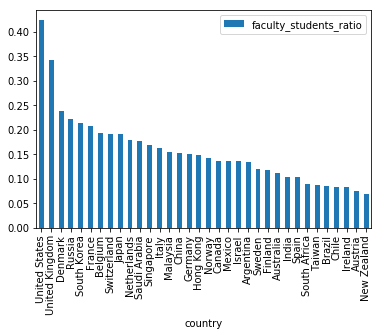

In [11]:
qs_df = qs_df.reset_index()
aggregate_analyze(qs_df, 'country', 'faculty_students_ratio')

,name,international_ratio
country,,
Argentina,Universidad de Buenos Aires (UBA),0.221658
Australia,The University of Melbourne,0.427434
Austria,University of Vienna,0.314748
Belgium,Vrije Universiteit Brussel (VUB),0.199591
Brazil,Universidade Estadual de Campinas (Unicamp),0.036354
Canada,McGill University,0.330825
Chile,Universidad de Chile,0.054932
China,Peking University,0.168265
Denmark,Technical University of Denmark,0.236314


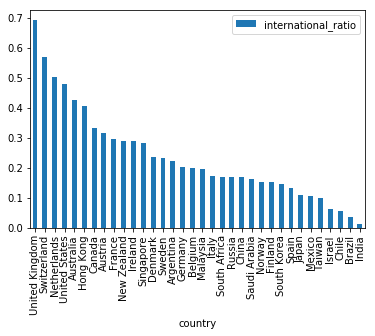

In [12]:
aggregate_analyze(qs_df, 'country', 'international_ratio')

,name,faculty_students_ratio
region,,
Africa,University of Cape Town,0.088450
Asia,Pohang University of Science And Technology (P...,0.213025
Europe,University of Oxford,0.342292
Latin America,Instituto Tecnológico y de Estudios Superiores...,0.136214
North America,California Institute of Technology (Caltech),0.422616
Oceania,The Australian National University,0.110788


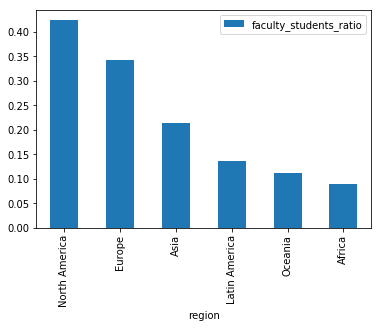

In [13]:
aggregate_analyze(qs_df, 'region', 'faculty_students_ratio')

,name,international_ratio
region,,
Africa,University of Cape Town,0.169703
Asia,The University of Hong Kong,0.407144
Europe,London School of Economics and Political Scien...,0.691393
Latin America,Universidad de Buenos Aires (UBA),0.221658
North America,Carnegie Mellon University,0.478062
Oceania,The University of Melbourne,0.427434


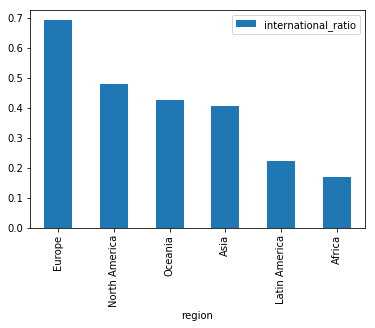

In [14]:
aggregate_analyze(qs_df, 'region', 'international_ratio')

## Task 2
We now obtain the 200 top-ranking universities from www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)) and repeat the previous analysis.

In [15]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
the_dataset = r.json()['data']

In [16]:
the_dataset[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

In [19]:
results = []
for university in the_dataset[:200]:
    results.append({
            'name': university['name'],
            'rank': parseInt(university['rank']),
            'country': university['location'],
            'faculty_students_ratio': 1 / parseDecimal(university['stats_student_staff_ratio']),
            'international_ratio': parseDecimal(university['stats_pc_intl_students']) / 100,
            'students_total': parseInt(university['stats_number_students'])
        })

the_df = pd.DataFrame.from_dict(results).set_index('name')

# Compute derived attributes (where applicable)
the_df['students_international'] = (the_df['students_total'] * the_df['international_ratio']).astype('int')
the_df['faculty_total'] = (the_df['students_total'] * the_df['faculty_students_ratio']).astype('int')

In [20]:
# Map countries to regions using the QS dataset
mapping = qs_df[['country', 'region']].set_index('country').to_dict()['region']

# Manually add missing mappings
mapping['Luxembourg'] = 'Europe'
mapping['Russian Federation'] = 'Europe'

the_df['region'] = the_df['country'].replace(mapping)
the_df.head()

,country,faculty_students_ratio,international_ratio,rank,students_total,students_international,faculty_total,region
name,,,,,,,,
University of Oxford,United Kingdom,0.089286,0.38,1,20409,7755,1822,Europe
University of Cambridge,United Kingdom,0.091743,0.35,2,18389,6436,1687,Europe
California Institute of Technology,United States,0.153846,0.27,3,2209,596,339,North America
Stanford University,United States,0.133333,0.22,3,15845,3485,2112,North America
Massachusetts Institute of Technology,United States,0.114943,0.34,5,11177,3800,1284,North America


In [21]:
the_df.sort_values('faculty_students_ratio', ascending=False).head()

,country,faculty_students_ratio,international_ratio,rank,students_total,students_international,faculty_total,region
name,,,,,,,,
Vanderbilt University,United States,0.303030,0.13,105,12011,1561,3639,North America
University of Copenhagen,Denmark,0.243902,0.14,109,30395,4255,7413,Europe
University of Rochester,United States,0.232558,0.29,153,9636,2794,2240,North America
Yale University,United States,0.232558,0.21,12,12155,2552,2826,North America
Johns Hopkins University,United States,0.232558,0.24,13,15498,3719,3604,North America


In [22]:
the_df.sort_values('international_ratio', ascending=False).head()

,country,faculty_students_ratio,international_ratio,rank,students_total,students_international,faculty_total,region
name,,,,,,,,
London School of Economics and Political Science,United Kingdom,0.081967,0.71,25,10065,7146,825,Europe
University of Luxembourg,Luxembourg,0.068493,0.57,179,4969,2832,340,Europe
École Polytechnique Fédérale de Lausanne,Switzerland,0.089286,0.55,38,9928,5460,886,Europe
Imperial College London,United Kingdom,0.087719,0.55,8,15857,8721,1390,Europe
Maastricht University,Netherlands,0.055556,0.50,103,16727,8363,929,Europe


,name,faculty_students_ratio
country,,
Australia,Australian National University,0.051813
Austria,University of Vienna,0.048077
Belgium,Ghent University,0.027855
Canada,McGill University,0.075188
China,University of Science and Technology of China,0.121951
Denmark,University of Copenhagen,0.243902
Finland,University of Helsinki,0.061728
France,École Polytechnique,0.196078
Germany,LMU Munich,0.064103


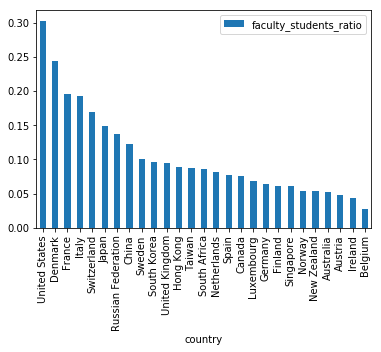

In [23]:
the_df = the_df.reset_index()
aggregate_analyze(the_df, 'country', 'faculty_students_ratio')

,name,international_ratio
country,,
Australia,University of Melbourne,0.40
Austria,University of Vienna,0.26
Belgium,Université Libre de Bruxelles,0.35
Canada,University of British Columbia,0.29
China,Peking University,0.16
Denmark,Technical University of Denmark,0.24
Finland,Aalto University,0.20
France,École Polytechnique,0.36
Germany,Technical University of Munich,0.23


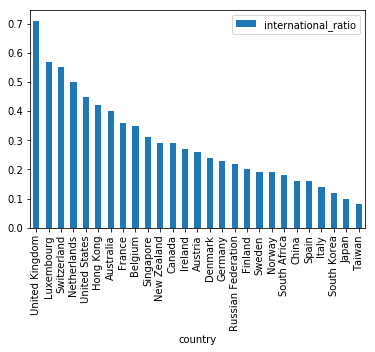

In [24]:
aggregate_analyze(the_df, 'country', 'international_ratio')

,name,faculty_students_ratio
region,,
Africa,University of Cape Town,0.085470
Asia,University of Tokyo,0.149254
Europe,University of Copenhagen,0.243902
North America,Vanderbilt University,0.303030
Oceania,University of Auckland,0.053191


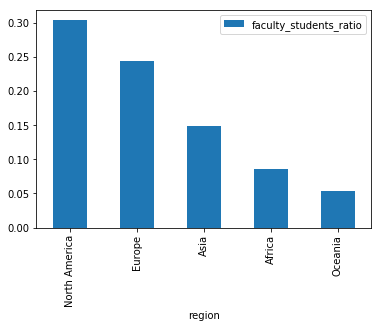

In [25]:
aggregate_analyze(the_df, 'region', 'faculty_students_ratio')

,name,international_ratio
region,,
Africa,University of Cape Town,0.18
Asia,University of Hong Kong,0.42
Europe,London School of Economics and Political Science,0.71
North America,Carnegie Mellon University,0.45
Oceania,University of Melbourne,0.40


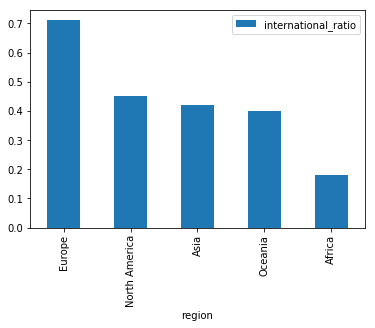

In [26]:
aggregate_analyze(the_df, 'region', 'international_ratio')

In [68]:
not_matched_counter = 0

qs_df_ = qs_df.copy()
the_df_ = the_df.copy()
def mapName(name):
    global not_matched_counter
    tolerance = 0.6
    res = difflib.get_close_matches(name, the_df_['name'], 1, tolerance)
    if len(res) > 0:
        back_res = difflib.get_close_matches(res[0], qs_df_['name'], 1, tolerance)
        if len(back_res) > 0 and name == back_res[0]:
            return res[0]
    not_matched_counter += 1
    return name

qs_df_['name'] = qs_df_['name'].map(mapName)
print(not_matched_counter, 'universities were not matched.')
merged_df = qs_df_.merge(the_df_, on='name', how='outer', suffixes=('_qs', '_the'))
merged_df

49 universities were not matched.


,name,country_qs,faculty_international,faculty_total_qs,rank_qs,region_qs,students_international_qs,students_total_qs,faculty_students_ratio_qs,international_ratio_qs,country_the,faculty_students_ratio_the,international_ratio_the,rank_the,students_total_the,students_international_the,faculty_total_the,region_the
0,Massachusetts Institute of Technology,United States,1679.0,2982.0,1.0,North America,3717.0,11067.0,0.269450,0.335863,United States,0.114943,0.34,5.0,11177.0,3800.0,1284.0,North America
1,Stanford University,United States,2042.0,4285.0,2.0,North America,3611.0,15878.0,0.269870,0.227422,United States,0.133333,0.22,3.0,15845.0,3485.0,2112.0,North America
2,Harvard University,United States,1311.0,4350.0,3.0,North America,5266.0,22429.0,0.193945,0.234785,United States,0.112360,0.26,6.0,20326.0,5284.0,2283.0,North America
3,California Institute of Technology,United States,350.0,953.0,4.0,North America,647.0,2255.0,0.422616,0.286918,United States,0.153846,0.27,3.0,2209.0,596.0,339.0,North America
4,University of Cambridge,United Kingdom,2278.0,5490.0,5.0,Europe,6699.0,18770.0,0.292488,0.356899,United Kingdom,0.091743,0.35,2.0,18389.0,6436.0,1687.0,Europe
5,University of Oxford,United Kingdom,2964.0,6750.0,6.0,Europe,7353.0,19720.0,0.342292,0.372870,United Kingdom,0.089286,0.38,1.0,20409.0,7755.0,1822.0,Europe
6,University College London,United Kingdom,2554.0,6345.0,7.0,Europe,14854.0,31080.0,0.204151,0.477928,United Kingdom,0.095238,0.49,16.0,30304.0,14848.0,2886.0,Europe
7,Imperial College London,United Kingdom,2071.0,3930.0,8.0,Europe,8746.0,16090.0,0.244251,0.543567,United Kingdom,0.087719,0.55,8.0,15857.0,8721.0,1390.0,Europe
8,University of Chicago,United States,635.0,2449.0,9.0,North America,3379.0,13557.0,0.180645,0.249244,United States,0.161290,0.25,9.0,13525.0,3381.0,2181.0,North America
9,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,1886.0,2477.0,10.0,Europe,7563.0,19815.0,0.125006,0.381681,Switzerland,0.068493,0.38,10.0,19233.0,7308.0,1317.0,Europe


In [70]:
cols_qs = merged_df[['rank_qs', 'faculty_total_qs', 'students_international_qs',
                  'students_total_qs', 'faculty_students_ratio_qs', 'international_ratio_qs']]
cols_the = merged_df[['rank_the', 'faculty_total_the', 'students_international_the',
                  'students_total_the', 'faculty_students_ratio_the', 'international_ratio_the']]
cols_qs.columns = cols_qs.columns.map(lambda x: x.rstrip('_qs'))
cols_the.columns = cols_the.columns.map(lambda x: x.rstrip('_the'))
cols_qs.corrwith(cols_the)

rank                      0.689643
faculty_total             0.697652
students_international    0.890919
students_total            0.944379
faculty_students_ratio    0.712781
international_ratio       0.952672
dtype: float64

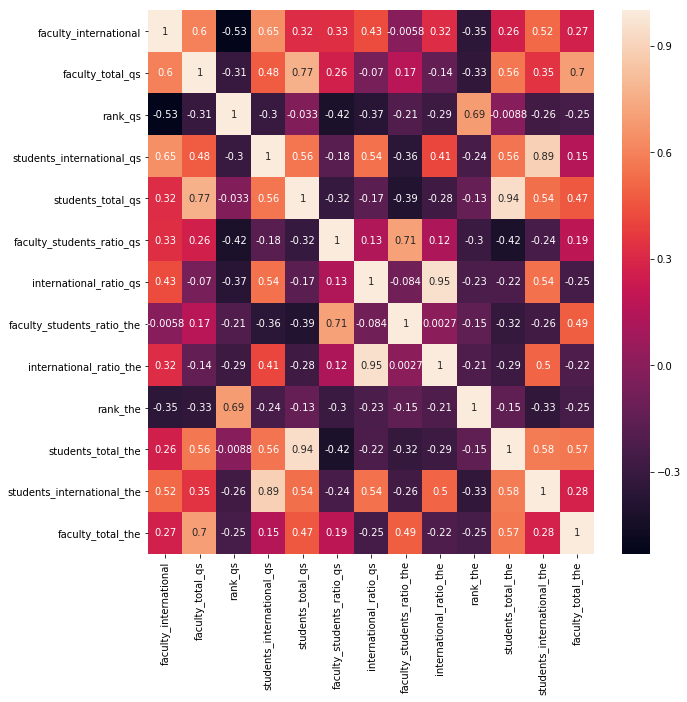

In [72]:
corr = merged_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [99]:
corr_pairs = abs(corr).unstack().reset_index()
corr_pairs.columns = [['var1', 'var2', 'corr']]
corr_pairs = corr_pairs[corr_pairs['var1'] > corr_pairs['var2']] # Remove redundant entries
corr_pairs[corr_pairs['corr'] > 0.5].sort_values('corr', ascending=False)

,var1,var2,corr
110,international_ratio_the,international_ratio_qs,0.952672
134,students_total_the,students_total_qs,0.944379
146,students_international_the,students_international_qs,0.890919
53,students_total_qs,faculty_total_qs,0.767160
96,faculty_students_ratio_the,faculty_students_ratio_qs,0.712781
157,faculty_total_the,faculty_total_qs,0.697652
119,rank_the,rank_qs,0.689643
39,students_international_qs,faculty_international,0.646589
13,faculty_total_qs,faculty_international,0.596562
141,students_total_the,students_international_the,0.578362


In [108]:
rankings = merged_df[['name', 'rank_qs', 'rank_the']].copy()
rankings['rank_avg'] = (rankings['rank_qs'] + rankings['rank_the'])/2
rankings.sort_values('rank_avg', ascending=True).head(10)

,name,rank_qs,rank_the,rank_avg
1,Stanford University,2.0,3.0,2.5
0,Massachusetts Institute of Technology,1.0,5.0,3.0
3,California Institute of Technology,4.0,3.0,3.5
4,University of Cambridge,5.0,2.0,3.5
5,University of Oxford,6.0,1.0,3.5
2,Harvard University,3.0,6.0,4.5
7,Imperial College London,8.0,8.0,8.0
8,University of Chicago,9.0,9.0,9.0
9,ETH Zurich – Swiss Federal Institute of Techno...,10.0,10.0,10.0
12,Princeton University,13.0,7.0,10.0
